In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.SpaceMMiCRM

In [2]:
using CairoMakie, ProgressLogging
using Base.Threads
using BenchmarkTools
using JLD2, Geppetto
using Random, Distributions, Statistics

In [3]:
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# ODE/PDE Solving

## Basic no space solve

In [4]:
function random_matrix_initialization(S, M, c_sparsity=1.0, l_sparsity=0.35)
    # 110425 to start let us just randomly draw D and c without structure
    # similarly, we will generate some random guesses for the other parameters

    # constant dilution rate
    rnd = rand()
    r = fill(rnd,M)

    # universal death rate
    rnd2 = rand()
    m = rnd2

    # for simplicity, lets start with a single fed resource
    # chemostat feed rate 
    #K = fill(0.,M)
    #K[1] = 1.

    # lets allow resources some variability
    #K_dist = truncated(Normal(0.5,0.1), 0.0, 1.0)
    K_dist = Beta(0.1,0.3)
    K = rand(K_dist, M)


    # leakage now. Lets assume its a pretty flat probability distribution
    leak = Beta(0.2/l_sparsity,0.2)
    l = rand(leak,(S,M))

    # most values around 0. This is essentially a proxy for sparsity
    c_i_alpha = Beta(0.5/c_sparsity,0.5)
    c = rand(c_i_alpha,(S,M))
    
    # finally, the most complicated distribution
    D = fill(0.,(S,M,M))
    for i in 1:S
        for j in 1:M
            if c[i,j] > 0
                flag = true
                while flag
                    for k in 1:M
                        if j == k
                            D[i,k,j] = 0.0
                        else
                            D[i,k,j] = rand(Beta(0.5/(M/5),0.5))
                        end
                    end
                    # check if the sum of the row is less than 1
                    if sum(D[i,:,j]) < 1.0
                        flag = false
                    end
                end
            end

        end
    end


    Ds = fill(0.,(S+M))
    Ds[1:S] .= 1e-5
    Ds[1+S] = 100
    Ds[S+2:S+M] .= 10

    return r, m, K, l, c, D, Ds

   
    

end

random_matrix_initialization (generic function with 3 methods)

In [5]:
function BinaryRandomMatrix(a,b, p)
    # Generate a random binary matrix of size a x b with probability of 1 = p
    r = rand(a, b)
    m = fill(0, a, b)

    for i in 1:a
        for j in 1:b
            if r[i,j] < p
                m[i,j] = 1
            end
        end
    end
    
    return  m
end

BinaryRandomMatrix (generic function with 1 method)

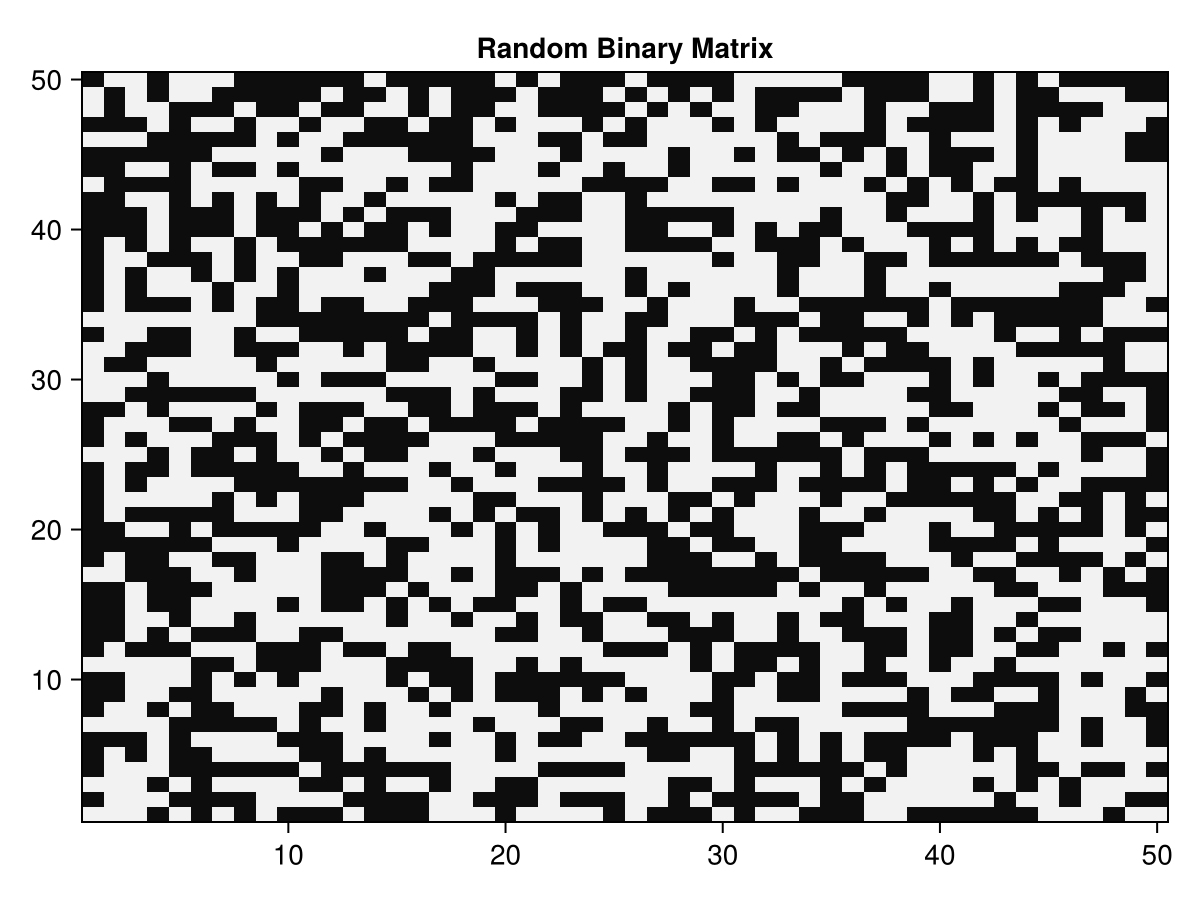

CairoMakie.Screen{IMAGE}


In [6]:
test = BinaryRandomMatrix(50, 50, 0.5)

#visualize
f = Figure()
ax = Axis(f[1, 1], title = "Random Binary Matrix")
heatmap!(ax, test, colormap = :grays)
f[1, 1] = ax
display(f)

Dirichlet: [0.09821339592157732, 0.09835056186692018, 0.11104948472787235, 0.0402909901907649, 0.25294405715453655, 4.020897604456039e-5, 0.011125057660414979, 0.010762402663924819, 0.021478159515013123, 0.31631427779618065, 1.7146951177677357e-74, 4.500254822087587e-12, 1.6385742038621675e-90, 1.3899968262643127e-113, 4.340557679820636e-230, 9.149538880492622e-23, 2.6110714130264424e-22, 3.00965264840424e-11, 1.814544320202392e-88, 9.442556167608925e-204, 2.0242947955399704e-31, 1.0107157044646492e-20, 4.3375113816218485e-21, 2.53738909952143e-35, 0.03934377070441383, 2.3535414660851196e-23, 2.456385976005586e-39, 8.967569936671713e-94, 5.893512949337045e-99, 3.4157113310293394e-27, 1.4509178054332803e-37, 4.998092725076406e-6, 2.1100655354287354e-6, 1.3763996390822296e-80, 1.6160063861630893e-7, 3.9168758432167294e-13, 3.2115636199448595e-87, 2.9940894619893834e-31, 2.645118806529511e-131, 9.83086787069134e-12, 2.1649727546324248e-10, 6.826454705214903e-5, 1.8449111448221818e-22, 1.4

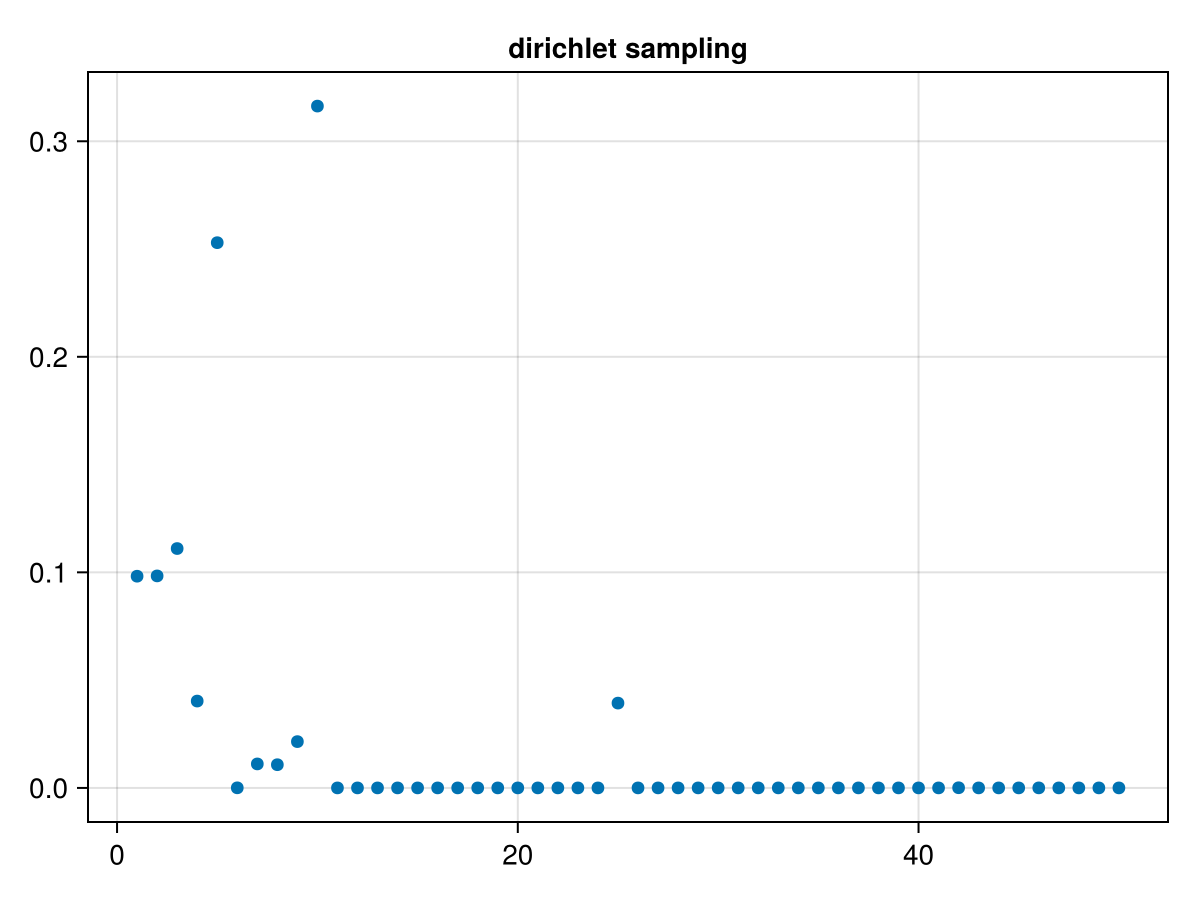

In [7]:
# testing dirichlet distribution

L = 10
M = 50

arr = fill(0.,M)
for i in 1:M
    if i<=L
        arr[i] = 0.5
    else
        arr[i] = 0.01
    end
end

dir = rand(Dirichlet(arr))
println("Dirichlet: ", dir)
f = Figure()
ax = Axis(f[1, 1], title = "dirichlet sampling")
plot!(ax, dir, colormap = :grays)
f[1, 1] = ax
display(f)

println("dirichlet sum ", sum(dir))

In [105]:
function marsland_initialization(S, M,SA = 5,MA = 5, q = 0.9, c0=0.,c1=1., muc = 10,
        fs = 0.45, fw=0.45,sparsity=0.2,l=0.8)
    # To start we are going to make a speciofic subset of assumptions available in the Marsland and Cui code.


    # let us begin by assigning the whole array c0
    c = fill(c0/M,(S,M))
    
    # now we will calculate the block structure of the matrix
    F = ceil(M/MA) #number of resource classes
    T = ceil(S/SA) #number of species classes
    S_overlap = S%SA # number of species in the last class
    M_overlap = M%MA # number of resources in the last class
    # we will always assume that the last species class is the "general" class 
    println("T: ", T, " F: ", F)

    # we will sample the consumption matrix in block form
    
    for tt in 1:T
        for ff in 1:F
            if tt != T
                if ff == tt
                    p = muc/(M*c1)*(1+q*(M-MA)/M)
                else
                    p = muc/(M*c1)*(1-q)
                end

                if ff*MA > M
                    # ensure that the last block is not larger than the matrix
                    block = BinaryRandomMatrix(SA,M_overlap,p)
                    c[Int(1+SA*(tt-1)):Int(tt*SA), Int(1+MA*(ff-1)):Int(M)] .= block
                else
                    block = BinaryRandomMatrix(SA,MA,p)
                    c[Int(1+SA*(tt-1)):Int(tt*SA), Int(1+MA*(ff-1)):Int(ff*MA)] .= block
                end

            else
                # generalist class
                p = muc/(M*c1)
                if S_overlap != 0
                    block = BinaryRandomMatrix(S_overlap,M,p)
                    c[Int(1+SA*(tt-1)):Int(S), :] .= block
                else
                    
                    block = BinaryRandomMatrix(SA,M,p)
                    c[Int(1+SA*(tt-1)):Int(tt*SA), :] .= block
                end
            end
        end
    end
    

    # Time for D_iab
    strain_class = 0
    D = fill(0.,(S,M,M))
    for i in 1:S
        if (i-1)%SA ==0
            strain_class += 1
            #println("Class: ", class, " i: ", i)
        end

        resource_class = 0
        for j in 1:M
            if (j-1)%MA == 0
                resource_class +=1
            end

            #start with background levels
            bkg = (1-fw-fs)/(M - MA)
            p = fill(bkg,M)
            
            if resource_class == strain_class
                if strain_class == T
                    if M_overlap != 0
                        p[(M-M_overlap):M] .= fw + fs
                    else
                        p[(M-MA):M] .= fw + fs
                    end
                else
                    #the within class resource
                    upper_limit = minimum(((strain_class-1)*MA+MA,M))
                    p[1+(strain_class-1)*MA:upper_limit] .= fs

                    # the waste resources
                    if M_overlap != 0
                        p[(M-M_overlap):M] .= fw
                    else
                        p[(M-MA):M] .= fw
                    end
                end
            else
                p = fill(1.,M)
            end
            


            #lets sample the distribution
            vec = rand(Dirichlet(p))
            D[i,:,j] = vec

        end
    end
    

    # constant dilution rate
    rnd = rand()
    r = fill(rnd,M)

    # universal death rate
    rnd2 = rand()
    m = rnd2

    # for simplicity, lets start with a single fed resource
    # chemostat feed rate 
    #K = fill(0.,M)
    #K[1] = 1.

    # lets allow resources some variability
    #K_dist = truncated(Normal(0.5,0.1), 0.0, 1.0)
    K_dist = Beta(0.1,0.3)
    K = rand(K_dist, M)


    # leakage now. Lets assume its a pretty flat probability distribution
    leak = Beta(0.2/sparsity,0.2)
    l = rand(leak,(S,M))


    Ds = fill(0.,(S+M))
    Ds[1:S] .= 1e-5
    Ds[1+S] = 100
    Ds[S+2:S+M] .= 10

    return r, m, K, l,c, D, Ds

end

marsland_initialization (generic function with 11 methods)

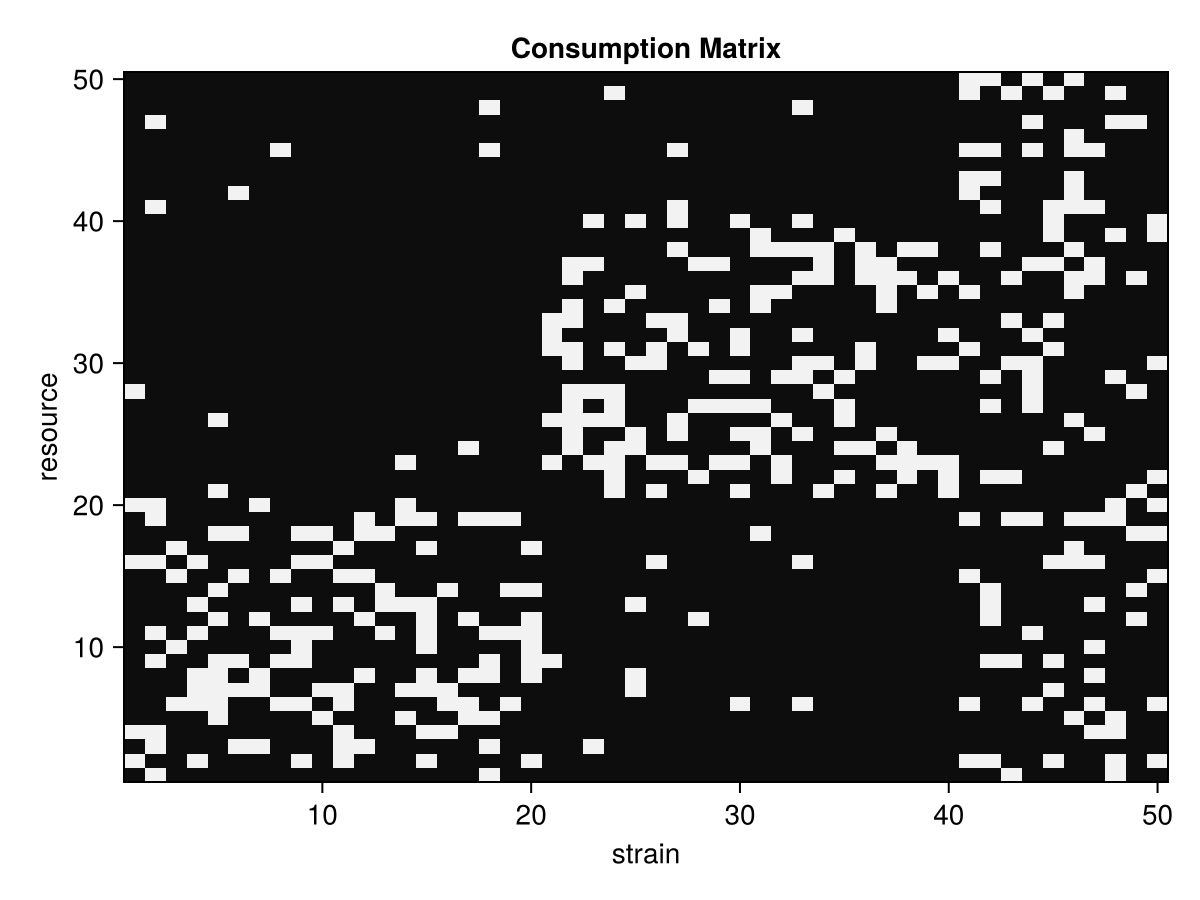

T: 3.0 F: 3.0
shape av: (1, 50, 50)


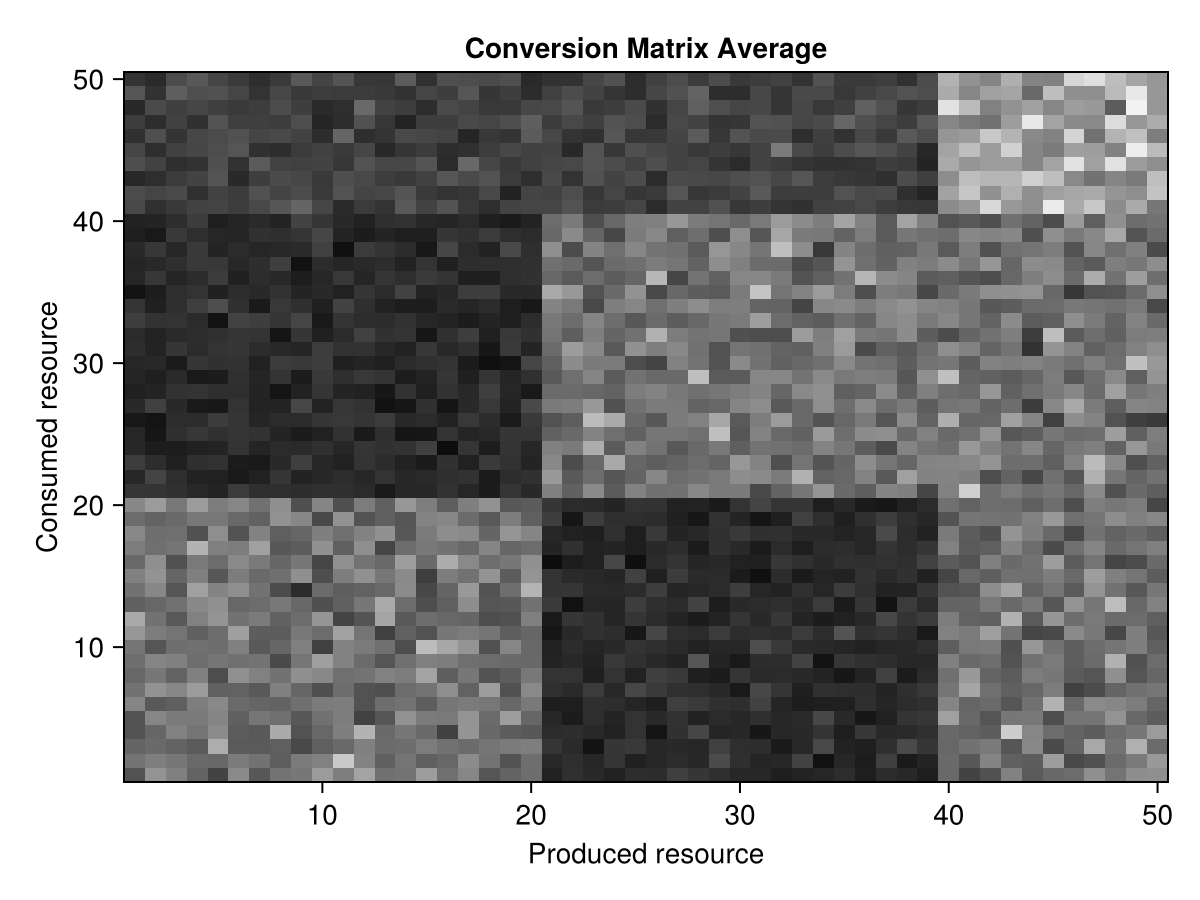

CairoMakie.Screen{IMAGE}


In [108]:
r, m, K, l, c, D, Ds = marsland_initialization(50,50,20,20)

# let's visualize the consumption matrix
f = Figure()
ax = Axis(f[1, 1], xlabel="strain", ylabel="resource", title = "Consumption Matrix")
heatmap!(ax, c, colormap = :grays)
#ax.yreversed = true
f[1, 1] = ax
display(f)
# let's visualize the leakage matrix
av = mean(D,dims=1)
println("shape av: ", size(av))
f = Figure()
ax = Axis(f[1, 1], xlabel="Produced resource", ylabel="Consumed resource", title = "Conversion Matrix Average")
heatmap!(ax, av[1,:,:], colormap = :grays)
#ax.yreversed = true
f[1, 1] = ax
display(f)


In [81]:
#=
# Let's start with basic "CoSMO"

#first define the number of Species and Resources
#number of species
S = 2
#number of resources
M = 3

# resource conversion matrix
D = fill(0., S, M, M)
D[1, 2, 1] = 1.
D[2, 3, 1] = 1.

# consumption matrix
c = fill(0., S, M)
c[1,1] = 1.
c[2,1] = 1.
c[1,3] = 1.
c[2,2] = 1.

# leakage fraction matrix
l = fill(0., S, M)
l[1,1] = 1.
l[2,1] = 1.

# chemostat feed rate 
K = fill(0.,M)
K[1] = 1.

# constant dilution rate
r = fill(0.3,M)

# universal death rate
m = 0.3
=#



In [112]:
# initialize the parameters
S = 50
M = 50
#r, m, K, l, c, D, Ds = random_matrix_initialization(S,M)
r, m, K, l, c, D, Ds = marsland_initialization(S,M,10,10)

T: 5.0 F: 5.0


([0.15778398059124277, 0.15778398059124277, 0.15778398059124277, 0.15778398059124277, 0.15778398059124277, 0.15778398059124277, 0.15778398059124277, 0.15778398059124277, 0.15778398059124277, 0.15778398059124277  …  0.15778398059124277, 0.15778398059124277, 0.15778398059124277, 0.15778398059124277, 0.15778398059124277, 0.15778398059124277, 0.15778398059124277, 0.15778398059124277, 0.15778398059124277, 0.15778398059124277], 0.9540438026475826, [0.14950296752923434, 0.004889822284615569, 0.006350422509939085, 5.611557906384405e-5, 0.16327620815660468, 5.929070844622183e-7, 0.012314922614394616, 0.13639365075373386, 4.7079956491088814e-5, 0.8918242648546073  …  0.044422374753880084, 6.365289001205635e-6, 0.9906729011909842, 0.996260555245771, 0.027477985374133054, 5.272807612659546e-7, 0.0023627889124685367, 5.332695915959951e-8, 8.321461827611103e-8, 0.9426562636307146], [0.9961400270140732 0.5448150952927591 … 0.9991131759222033 0.9994771931547396; 0.9999999999999912 0.9347324660982577 …

In [ ]:

p = make_mmicrm_smart(S, M, 500;
    D, c, l,
    K,r,m,
    u0=:onlyN,
    u0rand=0.
)
s = solve(p)
check_mmicrmparams(p.p)
display(plot_mmicrm_sol(s))
s[end]
#param_summary(p.p)

## Linear stability analysis

In [ ]:
usol = s[end]
show(uninplace(mmicrmfunc!)(usol, p.p, 0))

In [ ]:
ks = LinRange(0., 40., 10000)
#Ds = [1e-5,1e-5, 500, 10, 10]

lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
if maximum(real(lambdas)) > 0
    println("unstable!")
else
    println("stable :(")
end
# plot the eigenvalues
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.05, 0.05))
# xlims!(faa.axis, (0., 2.))
faa

In [ ]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

In [ ]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

## Probability of instability!

In [ ]:
# We are going to run a set of replicates to see how probable instability is
nrep = 1000

S = 20
M = 20  

instability = fill(0., nrep)

for ii in 1:nrep
    # initialize the parameters
    r, m, K, l, c, D, Ds = random_matrix_initialization(S,M)

    # create the model
    p = make_mmicrm_smart(S, M, 10000;
        D, c, l,
        K,r,m,
        u0=:onlyN,
        u0rand=0.
    )
    s = solve(p)

    usol = s[end]

    # check the stability
    ks = LinRange(0., 40., 10000)
    lambdas = do_linstab_for_ks(ks, p, Ds, usol);

    if maximum(real(lambdas)) > 0
        instability[ii] = 1.
    else
        instability[ii] = 0.
    end
    #println("replicate ", ii, " of ", nrep, " done")
end

println("fraction instability: ", sum(instability)/nrep)


fraction instability: 0.0


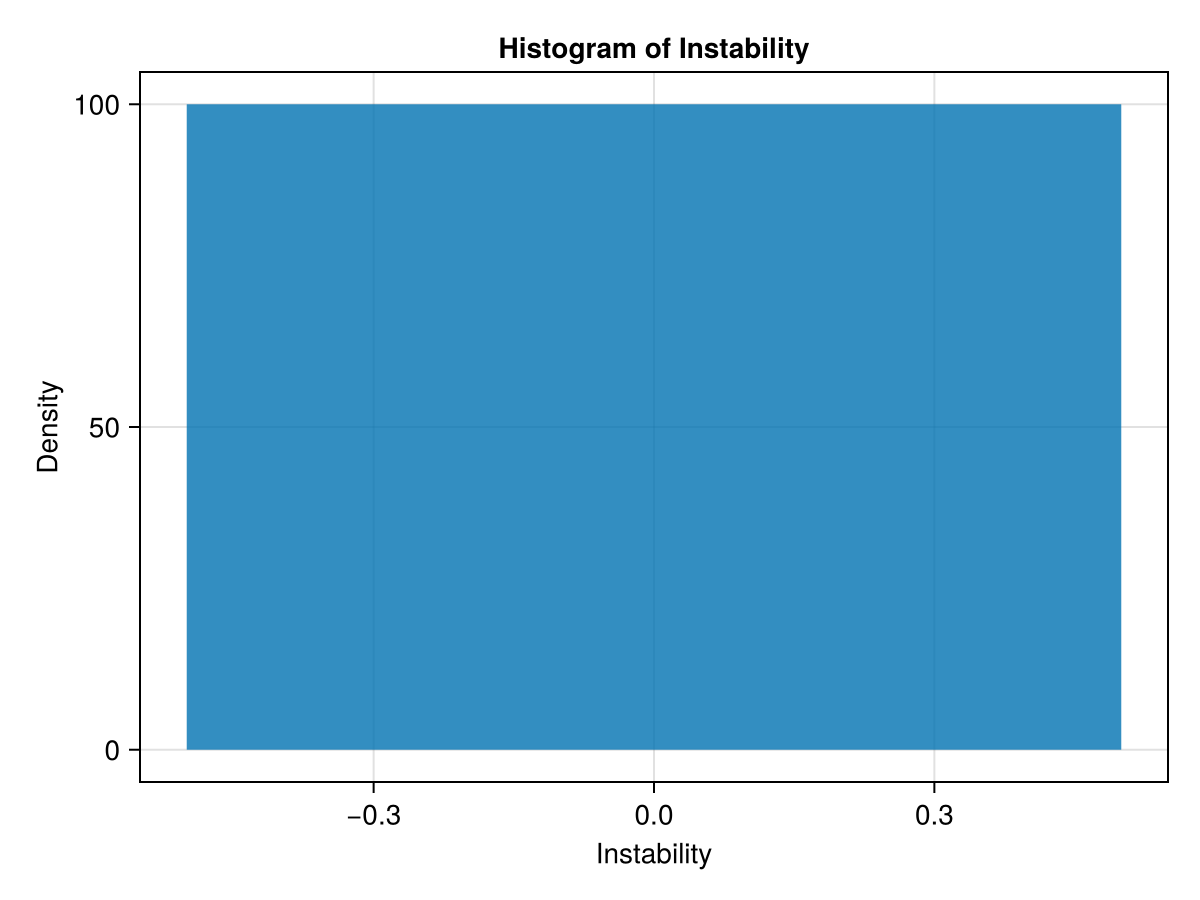

In [20]:
# check the histogram of instability
f = Figure()
ax = Axis(f[1, 1], title="Histogram of Instability", xlabel="Instability", ylabel="Density")
hist!(ax, instability, bins=2)#, normalization = :pdf)
f

In [ ]:
# Now we'll see % instability as a function of size

species = collect(2:10)
println("species: ", species)
nspecies = length(species)

perc_instability = fill(0., nspecies)


for x in 1:nspecies

    println(x)
    nrep = 1000

    S = species[x]
    M = species[x]

    println(S, " species")
    println(M, " resources")

    instability = fill(0., nrep)

    for ii in 1:nrep
        # initialize the parameters
        r, m, K, l, c, D, Ds = random_matrix_initialization(S,M)

        # create the model
        p = make_mmicrm_smart(S, M, 10000;
            D, c, l,
            K,r,m,
            u0=:onlyN,
            u0rand=0.
        )
        s = solve(p)

        usol = s[end]

        # check the stability
        ks = LinRange(0., 40., 4000)
        lambdas = do_linstab_for_ks(ks, p, Ds, usol);

        if maximum(real(lambdas)) > 0
            instability[ii] = 1.
        else
            instability[ii] = 0.
        end
        #println("replicate ", ii, " of ", nrep, " done")
    end


    perc_instability[x] = sum(instability)/nrep

    println("finished replicates for ", S, " species")
    println("fraction instability: ", perc_instability[x])
    
end

species: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
1
2 species
2 resources
finished replicates for 2 species
fraction instability: 0.015
2
4 species
4 resources
finished replicates for 4 species
fraction instability: 0.024
3
6 species
6 resources
finished replicates for 6 species
fraction instability: 0.017
4
8 species
8 resources
finished replicates for 8 species
fraction instability: 0.017
5
10 species
10 resources
finished replicates for 10 species
fraction instability: 0.017
6
12 species
12 resources
finished replicates for 12 species
fraction instability: 0.023
7
14 species
14 resources
finished replicates for 14 species
fraction instability: 0.017
8
16 species
16 resources
finished replicates for 16 species
fraction instability: 0.018
9
18 species
18 resources
finished replicates for 18 species
fraction instability: 0.019
10
20 species
20 resources
finished replicates for 20 species
fraction instability: 0.014


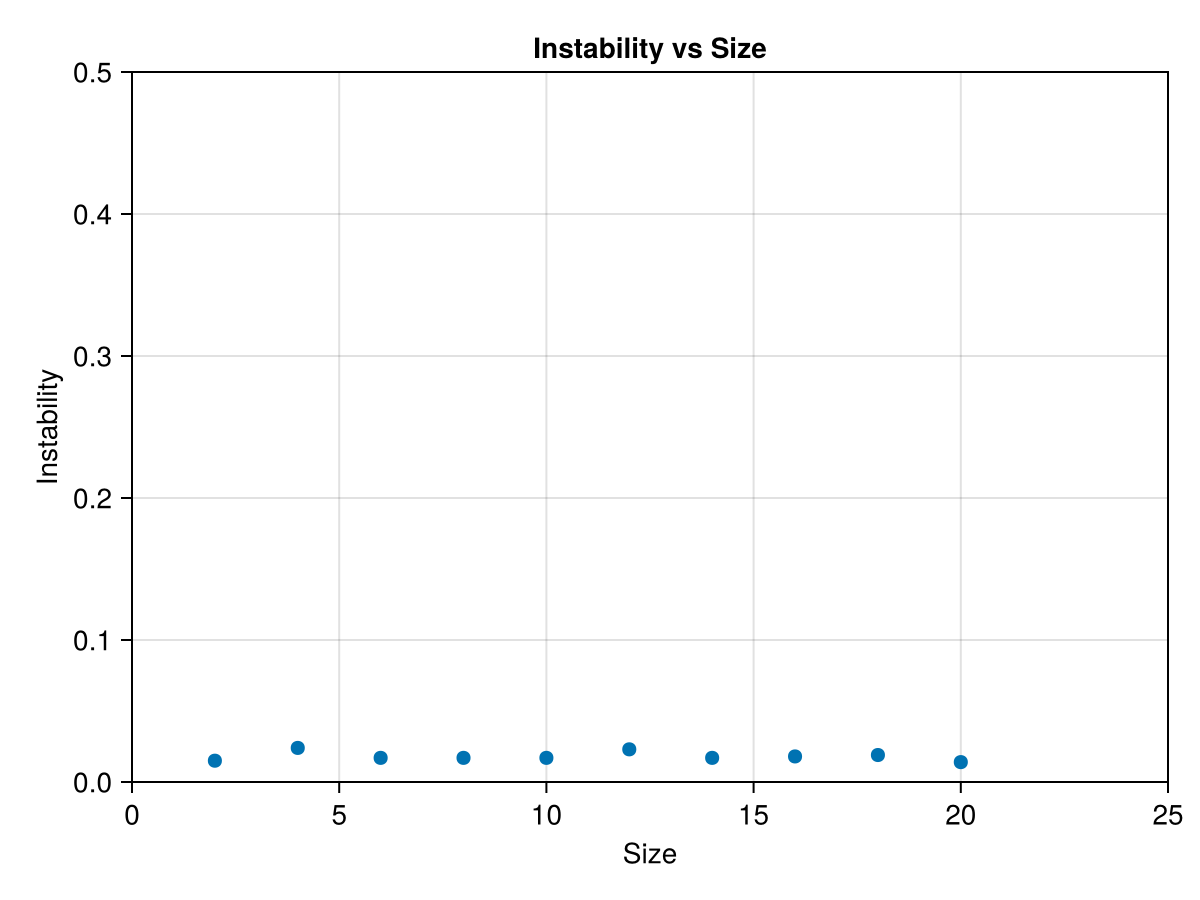

In [50]:
# plot the results
f = Figure()
ax = Axis(f[1, 1], title="Instability vs Size", xlabel="Size", ylabel="Instability")
scatter!(ax, species, perc_instability, markersize=10)
ylims!(ax, (0., 0.5))
xlims!(ax, (0., 25.))
f

In [55]:
# now let's see how the instability changes with sparsity and average leakage

nc = 5
nl = 5

repeats = 3
nrep = 20

instability = fill(0., (nc,nl,repeats,nrep))

for i in 1:nc
    c_sparsity = i/nc
    for j in 1:nl
        l_sparsity = j/nl
        for k in 1:repeats
            for q in 1:nrep
          
                # initialize the parameters
                S = 10
                M = 10

                r, m, K, l, c, D, Ds = random_matrix_initialization(S,M,c_sparsity,l_sparsity)

                # create the model
                p = make_mmicrm_smart(S, M, 500;
                    D, c, l,
                    K,r,m,
                    u0=:onlyN,
                    u0rand=0.
                )
                s = solve(p)
                usol = s[end]
                # check the stability
                ks = LinRange(0., 40., 10000)
                lambdas = do_linstab_for_ks(ks, p, Ds, usol)
                if maximum(real(lambdas)) > 0
                    instability[i,j,k,q] = 1.
                else
                    instability[i,j,k,q] = 0.
                end
                #println("replicate ", ii, " of ", nrep, " done")
            end
        end
    
    end
end



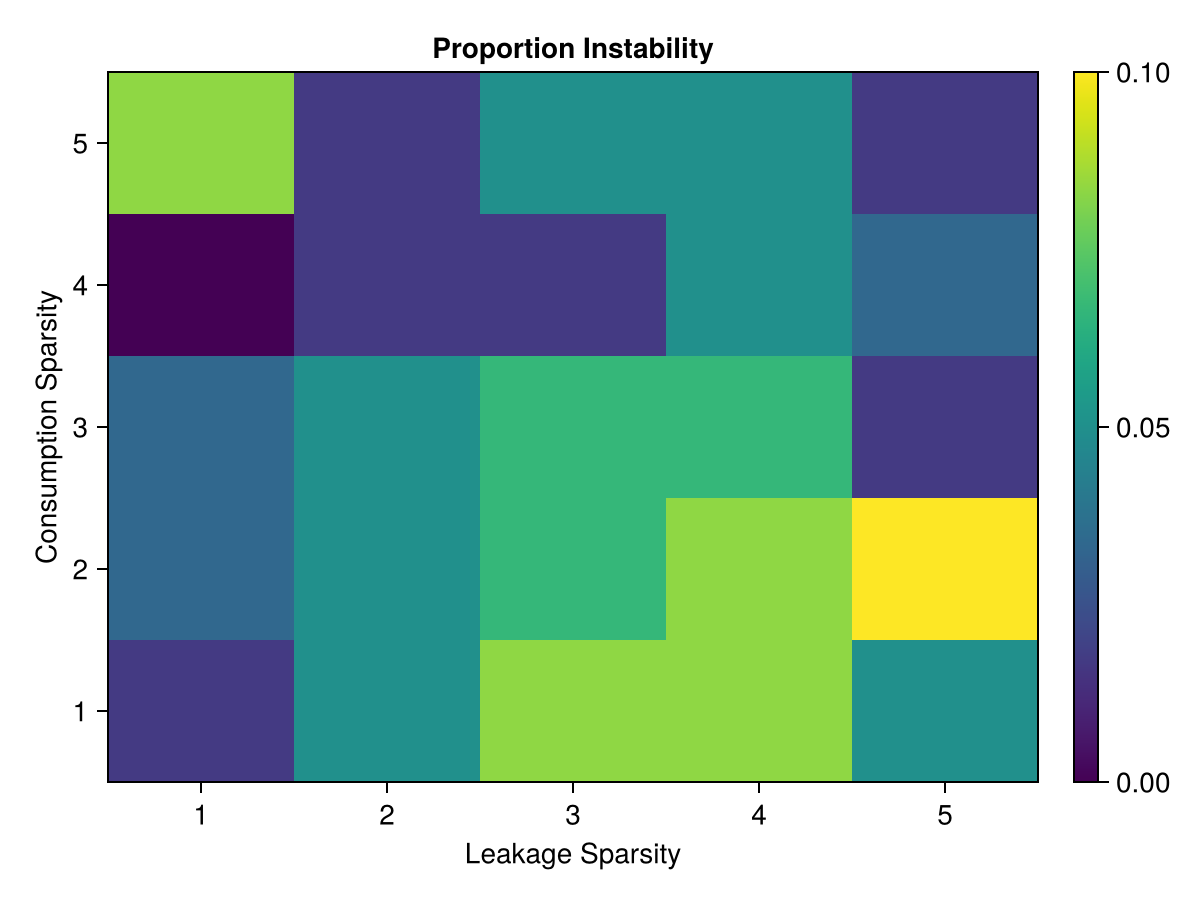

In [57]:
# lets plot the heatmap

# first we need to average over the repeats
instability_avg = fill(0., (nc,nl))
for i in 1:nc
    for j in 1:nl
        instability_avg[i,j] = sum(instability[i,j,:,:])/(repeats*nrep)
    end
end

# now we can plot the heatmap
fig, ax, hm = heatmap(instability_avg, colormap = :viridis, axis = (title = "Proportion Instability", xlabel = "Leakage Sparsity", ylabel = "Consumption Sparsity"))
Colorbar(fig[:, end+1], hm)
fig



## Spatial stuff - 1D!

In [88]:
ssize = (1000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.01, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 10000000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((40, 1000), 1, CartesianSpace{1, Tuple{Periodic}, Float64}([0.01]))

#### Direct solver

In [89]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)

 46.710585 seconds (29.09 M allocations: 12.288 GiB, 28.28% gc time, 27.83% compilation time)
Success
nf is 1065
solution has 206 saved states
max resid is 9.65108e-09


┌ Warning: reaching negative values, minimum is -4.33897e-06
└ @ SSMCMain.SpaceMMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/smmicrm_util.jl:10


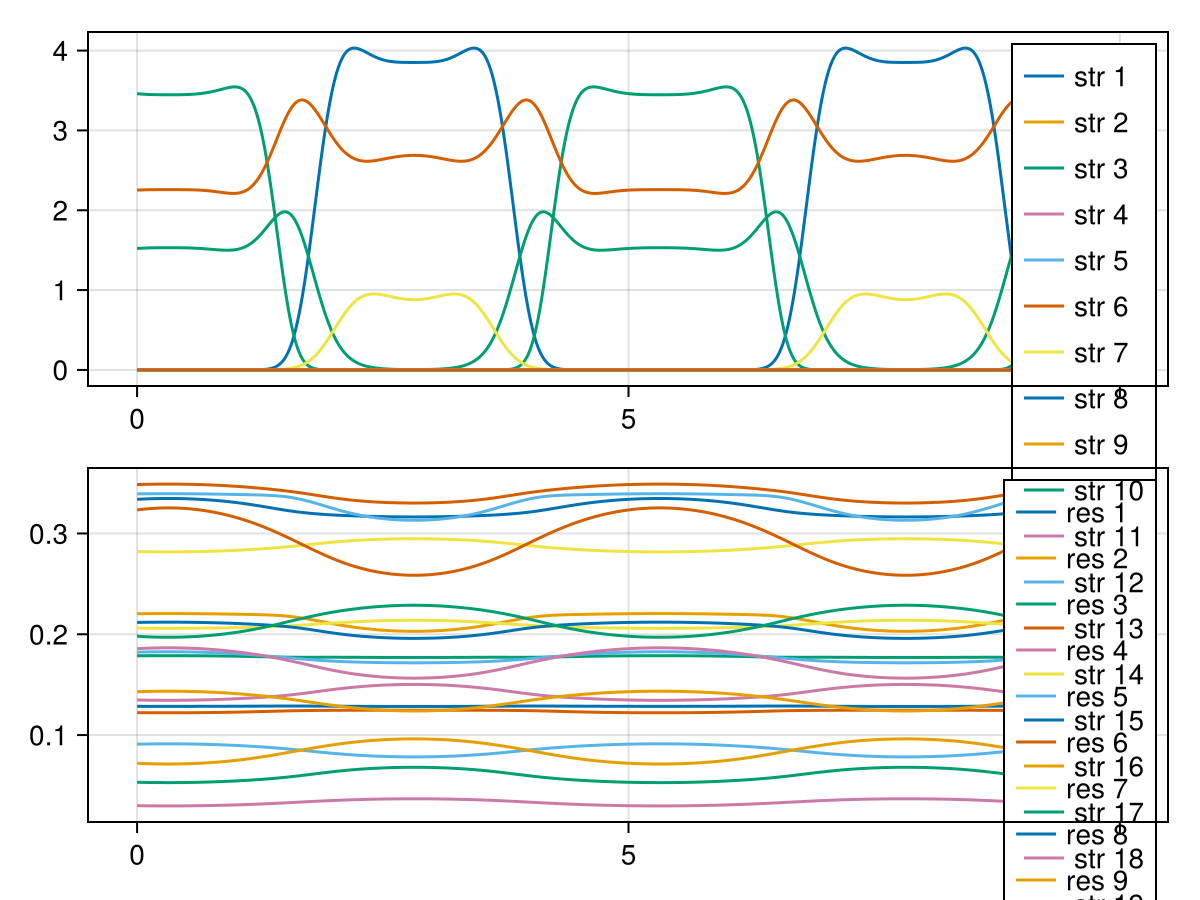

In [90]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps(sps.t[end]))

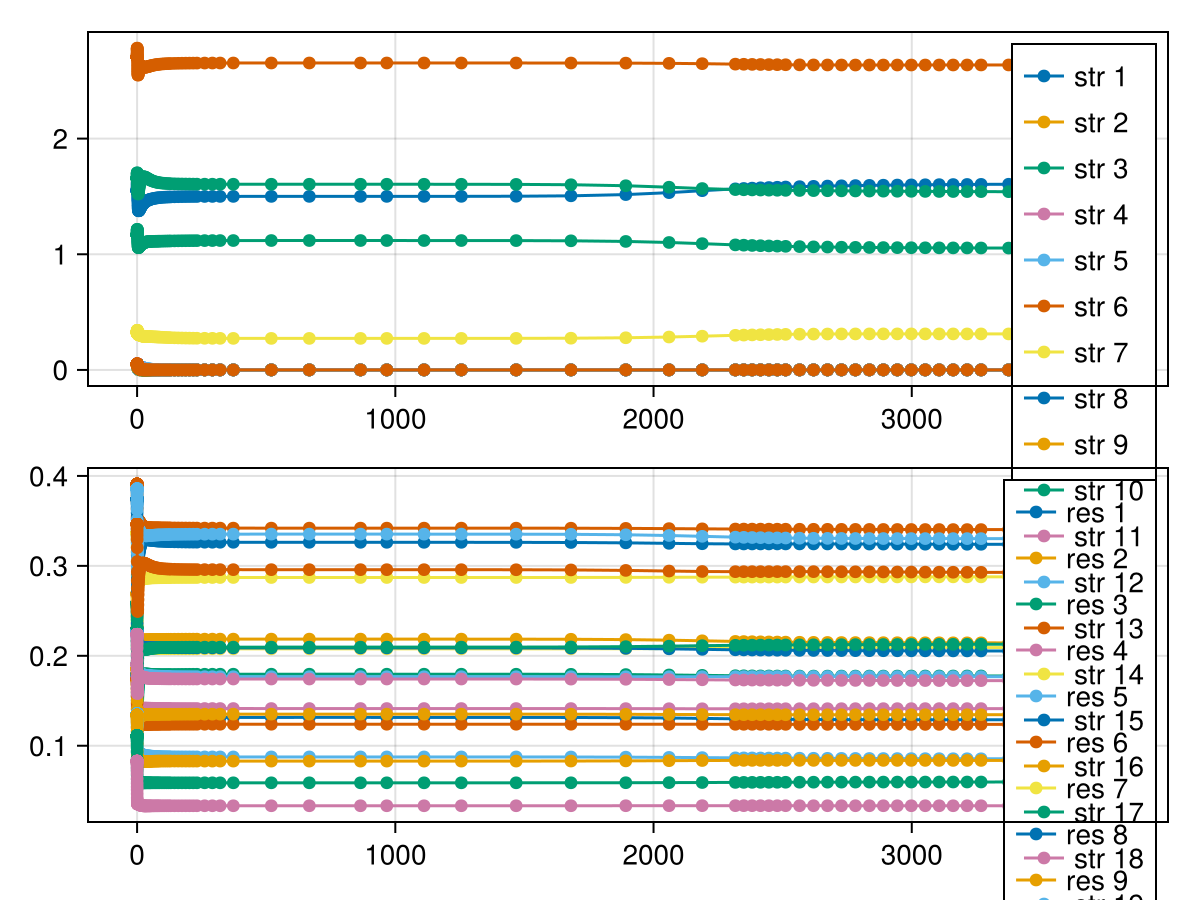

In [91]:
plot_smmicrm_sol_avgs(sps, 1:170)

#### Steady state solver

ReturnCode.Success = 1

1656

  2.612578 seconds (10.12 M allocations: 1012.315 MiB, 10.17% gc time, 77.99% compilation time)


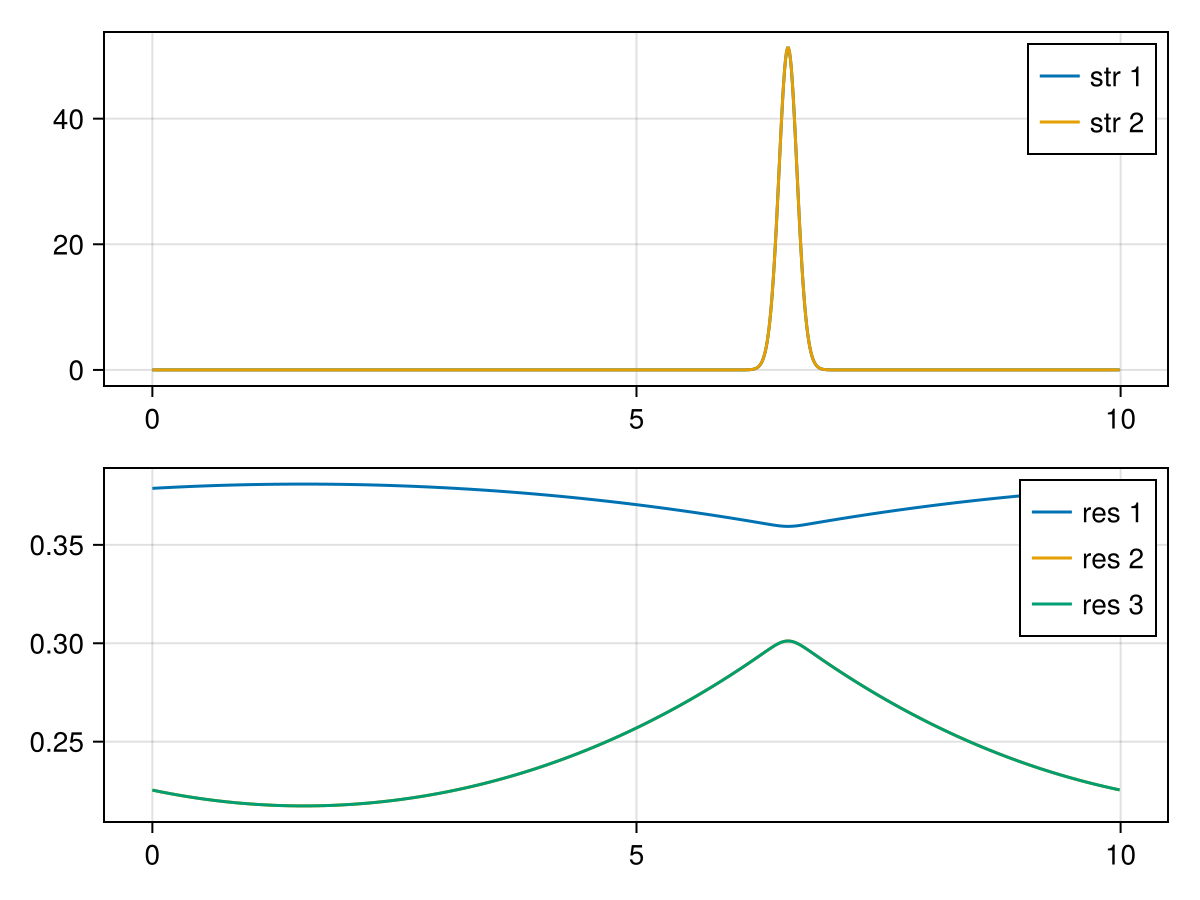

In [35]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

## Spatial stuff - 2D!

In [92]:
ssize = (60,60)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.1, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 100000000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((40, 60, 60), 1, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.1, 0.1]))

#### Direct solver

In [ ]:
@time sps = solve(sp, QNDF(); maxiters=10000)
print_spatial_solution_stats(sps)

In [ ]:
sps.prob.p

In [ ]:
f = plot_2dsmmicrm_sol_snap_heatmap(sps, -1)

In [11]:
f = plot_smmicrm_sol_avgs(sps; plote=true)
display(GLMakie.Screen(), f)

GLMakie.Screen(...)

In [12]:
f = plot_2dsmmicrm_sol_interactive_heatmap(sps)
display(GLMakie.Screen(), f)

GLMakie.Screen(...)

## Saving/loading

In [61]:
save_object(datadir("minimalmodel", randname()*".jld2"), sps)

In [9]:
sps = load_object("../data/minimalmodel/fascinating_maybe_moving.jld2");
print_spatial_solution_stats(sps)

MaxIters
nf is 110126
solution has 8608 saved states
max resid is 0.00431203


# Symbolics

In [5]:
using Symbolics, SymbolicsMathLink
import Nemo


Welcome to Nemo version 0.48.4

Nemo comes with absolutely no warranty whatsoever


In [6]:
function mycoeff(exp, var, power)
    s = Num(0)
    for t in Symbolics.terms(exp)
        if Symbolics.degree(t, var) == power
            s += t / (var^power)
        end
    end
    s
    # sum(filter(t->Symbolics.degree(t, var)==power, Symbolics.terms(exp)))
end

mycoeff (generic function with 1 method)

In [7]:
pvars = @variables m l K c d
fvars = @variables N G R
ssvars = @variables N_ss G_ss R_ss
Dvars = @variables D_N D_G D_R
@variables k;

In [8]:
sym_params = MMiCRMParams(
    Num.(p.p.g), Num.(p.p.w),
    SA[m],
    SA[K, 0.], Num.(SA[1., 1.]),
    SA[l 0.], SA[c d], Num.(p.p.D)
)
u = SA[N, G, R]
eqs = uninplace(mmicrmfunc!)(u, sym_params)

3-element SizedVector{3, Num, Vector{Num}} with indices SOneTo(3):
 (-m + R*d + G*c*(1.0 - l))*N
               -G + K - G*N*c
         -R - N*R*d + G*N*c*l

#### Analytic expressions for mixed (no space) steady states and their stability

express G and R in terms of N and then get a quadratic equation in N **ONLY VALID IF N IS NOT 0**

In [20]:
mR = symbolic_solve((eqs[1]/N)~0, R)[1]
mG = symbolic_solve(eqs[2]~0, G)[1]
display(R==mR)
display(G==mG)
feq = simplify(substitute(substitute(eqs[3], R=>mR), G=>mG)*(-d*(1+N*c)))
display(feq==0)

R == ((-m + G*c - G*c*l) / (-d))

G == (K / (1 + N*c))

(m - K*c + K*c*l + N*c*m + N*d*m - K*N*c*d + (N^2)*c*d*m) == 0

##### alternate expression for R that is valid even when N is 0, aka N=0 => R=0

In [21]:
mR2 = symbolic_solve(eqs[3]~0, R)[1]
display(Symbolics.variable(:R_v2)==mR2)

R_v2 == ((G*N*c*l) / (1 + N*d))

##### Interpretable solution?

In [22]:
c, b, a = mycoeff.(feq, N, 0:2)
display([a, b, c])
D = b^2 - 4*a*c

3-element Vector{Num}:
             c*d*m
 c*m + d*m - K*c*d
   m - K*c + K*c*l

(c*m + d*m - K*c*d)^2 - 4(m - K*c + K*c*l)*c*d*m

In [23]:
display(expand(D))
display(wcall("Simplify", wcall("Expand", D)))
display(wcall("FullSimplify", wcall("Expand", D)))
display(wcall("FullSimplify", D))
sD = wcall("FullSimplify", D);

(c^2)*(m^2) - (2//1)*c*d*(m^2) + (d^2)*(m^2) + (2//1)*K*(c^2)*d*m - (2//1)*K*c*(d^2)*m + (K^2)*(c^2)*(d^2) - (4//1)*K*(c^2)*d*l*m

(d^2)*(m^2) - 2(m + K*d)*c*d*m + (m^2 + (K^2)*(d^2) + 2K*d*(1 - 2l)*m)*(c^2)

((c - d)^2)*(m^2) + (K^2)*(c^2)*(d^2) - 2K*c*(d + c*(-1 + 2l))*d*m

((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m

In [24]:
N1 = simplify((-b+sqrt(sD))/(2*a))

(sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m - d*m + K*c*d) / (2c*d*m)

##### Naively plugging this into forms for M1 and M (kinda pointless)

In [25]:
G1 = simplify(Num(substitute(mG, N=>N1)))
R1 = simplify(Num(substitute(mR, G=>G1)))
mssol1 = [N1, G1, R1]

3-element Vector{Num}:
                                                                                                            (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m - d*m + K*c*d) / (2c*d*m)
                                                                                                            (2K*d*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d)
 (-m*sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*(m^2) - d*(m^2) + K*c*d*m - (2//1)*K*c*d*l*m) / ((-sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*m - d*m - K*c*d)*d)

In [236]:
make_M1(sym_params, mssol1)

3×3 Matrix{Num}:
 -m + (-m*sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*(m^2) - d*(m^2) + K*c*d*m - (2//1)*K*c*d*l*m) / (-sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*m - d*m - K*c*d) + (2K*c*d*(1 - l)*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d)  …          (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m - d*m + K*c*d) / (2c*m)
                                                                                                                                                                                                              -((2K*c*d*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d))                                                                                                 0.0
             (2K*c*d*l*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d) + (m*sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*(m^2) + 

In [26]:
make_M1(sym_params, mssol1)

3×3 Matrix{Num}:
 -m + (-m*sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*(m^2) - d*(m^2) + K*c*d*m - (2//1)*K*c*d*l*m) / (-sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*m - d*m - K*c*d) + (2K*c*d*(1 - l)*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d)  …          (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m - d*m + K*c*d) / (2c*m)
                                                                                                                                                                                                              -((2K*c*d*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d))                                                                                                 0.0
             (2K*c*d*l*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d) + (m*sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*(m^2) + 

#### Ms with general/symbolic ss sol

In [24]:
symM1 = make_M1(sym_params, ssvars)

3×3 Matrix{Num}:
 -m + R_ss*d + G_ss*c*(1 - l)  N_ss*c*(1 - l)         N_ss*d
                      -G_ss*c   -1.0 - N_ss*c            0.0
           -R_ss*d + G_ss*c*l        N_ss*c*l  -1.0 - N_ss*d

In [25]:
export_expr_to_wolfram(symM1, datadir("minimalmodel", "ssymM1"))

In [23]:
symM = make_M(symM1, k, Dvars)

3×3 Matrix{Num}:
 -m + R_ss*d - D_N*(k^2) + G_ss*c*(1 - l)  …                     N_ss*d
                                  -G_ss*c                           0.0
                       -R_ss*d + G_ss*c*l     -1.0 - N_ss*d - D_R*(k^2)

In [199]:
export_expr_to_wolfram(symM, datadir(randname()))

#### Ms for the non-extinct solution where we keep only N_ss symbolic

In [33]:
mGss = substitute(mG, N=>ssvars[1])
mRss = substitute(mR2, [G=>mGss, N=>ssvars[1]])
display(mGss)
display(mRss)

K / (1 + N_ss*c)

(K*N_ss*c*l) / ((1 + N_ss*c)*(1 + N_ss*d))

In [45]:
simplify(make_M1(sym_params, [ssvars[1], mGss, mRss]))

3×3 Matrix{Num}:
 -m + (K*c*(1 - l)) / (1 + N_ss*c) + (K*N_ss*c*d*l) / ((1 + N_ss*c)*(1 + N_ss*d))  …  N_ss*c*(1 - l)         N_ss*d
                                                          -((K*c) / (1 + N_ss*c))      -1.0 - N_ss*c            0.0
           (K*c*l) / (1 + N_ss*c) + (-K*N_ss*c*d*l) / ((1 + N_ss*c)*(1 + N_ss*d))           N_ss*c*l  -1.0 - N_ss*d

#### More bits

##### Making the K polynomial

In [325]:
@variables a b c d e f g h i o p q K;
M = [a - o*K b c; d e - p*K f; g h i - q*K]
display(M)
detM = det(M)
edetM = expand(detM)

3×3 Matrix{Num}:
 a - K*o        b        c
       d  e - K*p        f
       g        h  i - K*q

a*e*i - a*f*h - b*d*i + b*f*g + c*d*h - c*e*g - K*a*e*q - K*a*i*p + K*b*d*q + K*c*g*p - K*e*i*o + K*f*h*o + (K^2)*a*p*q + (K^2)*e*o*q + (K^2)*i*o*p - (K^3)*o*p*q

In [326]:
Kcoeffs = mycoeff.(edetM, K, 0:3)

4-element Vector{Num}:
  a*e*i - a*f*h - b*d*i + b*f*g + c*d*h - c*e*g
 -a*e*q - a*i*p + b*d*q + c*g*p - e*i*o + f*h*o
                          a*p*q + e*o*q + i*o*p
                                         -o*p*q

In [327]:
simplify(expand(sum(Kcoeffs .* K.^(0:3))) == edetM)

true

In [328]:
string.(Kcoeffs)

4-element Vector{String}:
 "a*e*i - a*f*h - b*d*i + b*f*g + c*d*h - c*e*g"
 "-a*e*q - a*i*p + b*d*q + c*g*p - e*i*o + f*h*o"
 "a*p*q + e*o*q + i*o*p"
 "-o*p*q"

In [329]:
@variables a b c d e f g h i o p q K l;
fM = [a - o*K - l b c; d e - p*K - l f; g h i - q*K - l]
display(fM)
detfM = det(fM)
# simplify(detfM)
edetfM = expand(detfM)

3×3 Matrix{Num}:
 a - l - K*o            b            c
           d  e - l - K*p            f
           g            h  i - l - K*q

a*e*i - a*e*l - a*f*h - a*i*l + a*(l^2) - b*d*i + b*d*l + b*f*g + c*d*h - c*e*g + c*g*l - e*i*l + e*(l^2) + f*h*l + i*(l^2) - (l^3) - K*a*e*q - K*a*i*p + K*a*l*p + K*a*l*q + K*b*d*q + K*c*g*p - K*e*i*o + K*e*l*o + K*e*l*q + K*f*h*o + K*i*l*o + K*i*l*p - K*(l^2)*o - K*(l^2)*p - K*(l^2)*q + (K^2)*a*p*q + (K^2)*e*o*q + (K^2)*i*o*p - (K^2)*l*o*p - (K^2)*l*o*q - (K^2)*l*p*q - (K^3)*o*p*q

In [324]:
mycoeff.(edetfM, l, 0:3)

4-element Vector{Num}:
 a*e*i - a*f*h - b*d*i + b*f*g + c*d*h - c*e*g - K*a*e*q - K*a*i*p + K*b*d*q + K*c*g*p - K*e*i*o + K*f*h*o + (K^2)*a*p*q + (K^2)*e*o*q + (K^2)*i*o*p - (K^3)*o*p*q
                                            -a*e - a*i + b*d + c*g - e*i + f*h + K*a*p + K*a*q + K*e*o + K*e*q + K*i*o + K*i*p - (K^2)*o*p - (K^2)*o*q - (K^2)*p*q
                                                                                                                                       a + e + i - K*o - K*p - K*q
                                                                                                                                                                -1

# Extras

In [952]:
GC.gc()
empty!(Out)

Dict{Int64, Any}()